# Problem setting: Anomaly Detection for fluctuations of Gold Prices (Monthly in USD).

This jupyter notebook demonstrates the change-point detection of [Monthly gold prices since 1950 in USD (London market)](https://datahub.io/core/gold-prices).

First of all, download the data and visualize the contents.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("../demo_local/gold_data.csv")
df.head()

,date,price
0,1950-02-16,34.73
1,1950-03-16,34.73
2,1950-04-16,34.73
3,1950-05-16,34.73
4,1950-06-16,34.73


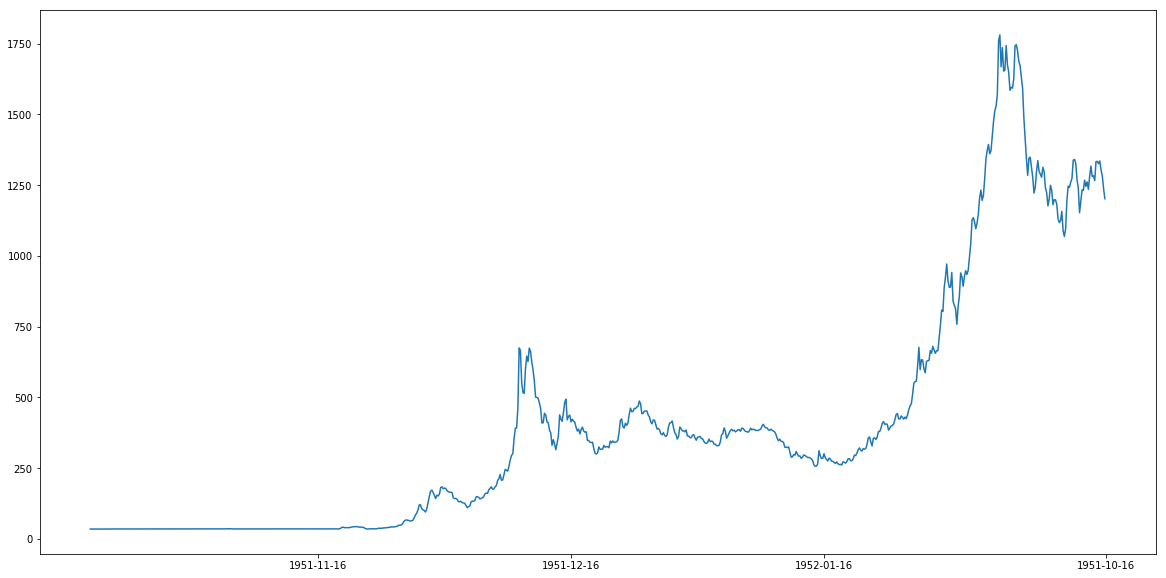

In [3]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(df.date.values[20:], df.price.values[20:])
ax.set_xticks([df.date.values[0], df.date.values[200], df.date.values[400], df.date.values[600]])
plt.show()

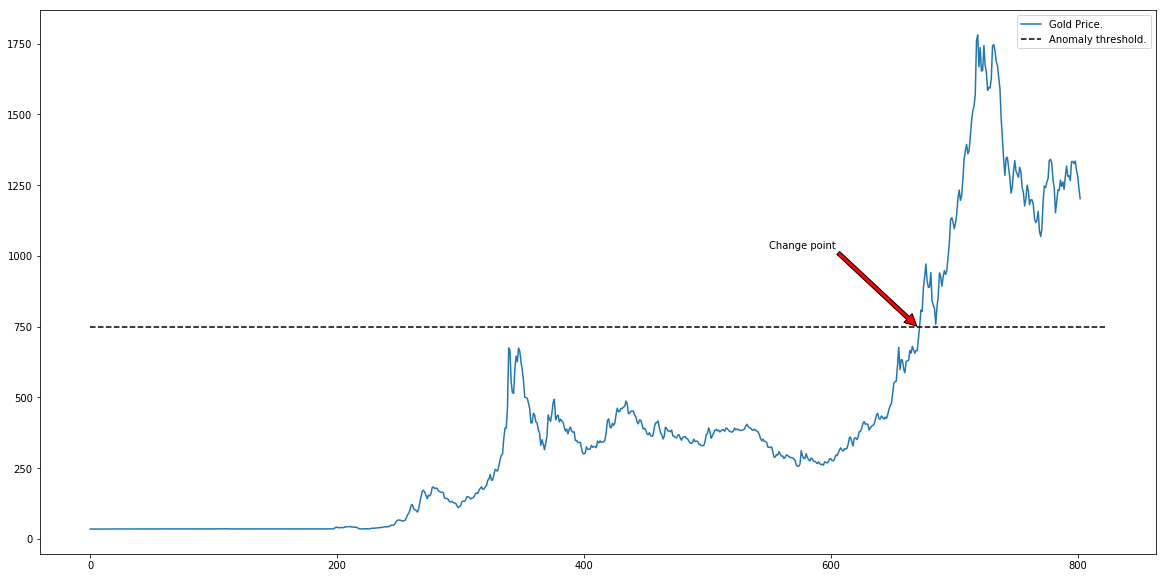

In [74]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(df.price.values[20:], label="Gold Price.")
ax.plot(np.array([750] * df.shape[0]), label="Anomaly threshold.", color="black", linestyle='dashed')
ax.annotate('Change point', xy=(670, 750), xytext=(550, 1025),
            arrowprops=dict(facecolor='red', shrink=0.005),
            )
plt.legend()
plt.show()

Here, for convenience, this notebook assumes that the near of 670 records is a change point. In other words, more than 700 values are regarded as outliers or abnormal values.

## Problem solution: Encoder-Decoder scheme for Anomaly Detection (EncDec-AD).

This notebook demonstrates the **Encoder-Decoder scheme for Anomaly Detection (EncDec-AD)** (Malhotra, P., et al. 2016), which learns to reconstruct *normal* time-series behavior, and thereafter uses reconstruction error to detect anomalies. Malhotra, P., et al. (2016) showed that EncDecAD paradigm is robust and can detect anomalies from predictable, unpredictable, periodic, aperiodic, and quasi-periodic time-series. Further, they showed that the paradigm is able to detect anomalies from short time-series (length as small as 30) as well as long time-series (length as large as 500).

### Preprocession

Convert the Gold Prices data to `np.ndarray`. The shape is (`The number of samples`, `The length of one sequence`, `Gold Prices`).

In [5]:
# The length of one sequence.
cycle_len = 20

# (`The number of samples`, `The length of one sequence`, `Gold Prices`)
observed_arr = np.empty((df.price.values.shape[0]-cycle_len, cycle_len, 1))
for row in range(cycle_len, df.price.values.shape[0]):
    observed_arr[row-cycle_len] = np.expand_dims(df.price.values[row-cycle_len:row], axis=1)

# Normalization.
observed_arr = (observed_arr - observed_arr.mean()) / observed_arr.std()

In EncDec-AD paradigm, training data should be composed of only *normal* time-series dataset. Considering that the near of 620 records is a change point, for simplicity, only range 0-620 rows is defined as *normal* time-series dataset.

In [6]:
# Training dataset.
train_arr = observed_arr[:670]

Import Python and Cython modules.

In [7]:
# LSTM Graph which is-a `Synapse`.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph
# Polymorphism.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as EncoderGraph
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as DecoderGraph
# Loss function.
from pydbm.loss.mean_squared_error import MeanSquaredError
# SGD as a Loss function.
from pydbm.optimization.optparams.sgd import SGD
# Adam as a Loss function.
from pydbm.optimization.optparams.adam import Adam as EncoderAdam
from pydbm.optimization.optparams.adam import Adam as DecoderAdam
# Verification.
from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation
# LSTM model.
from pydbm.rnn.lstm_model import LSTMModel
# Polymorphism.
from pydbm.rnn.lstm_model import LSTMModel as Encoder
from pydbm.rnn.lstm_model import LSTMModel as Decoder
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction
# Encoder/Decoder
from pydbm.rnn.encoder_decoder_controller import EncoderDecoderController

Instantiate objects and call the method.

In [8]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pydbm")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

In [9]:
# Init.
encoder_graph = EncoderGraph()

# Activation function in LSTM.
encoder_graph.observed_activating_function = TanhFunction()
encoder_graph.input_gate_activating_function = LogisticFunction()
encoder_graph.forget_gate_activating_function = LogisticFunction()
encoder_graph.output_gate_activating_function = LogisticFunction()
encoder_graph.hidden_activating_function = TanhFunction()
encoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
encoder_graph.create_rnn_cells(
    input_neuron_count=observed_arr.shape[-1],
    hidden_neuron_count=200,
    output_neuron_count=observed_arr.shape[-1]
)

In [10]:
# Init.
decoder_graph = DecoderGraph()

# Activation function in LSTM.
decoder_graph.observed_activating_function = TanhFunction()
decoder_graph.input_gate_activating_function = LogisticFunction()
decoder_graph.forget_gate_activating_function = LogisticFunction()
decoder_graph.output_gate_activating_function = LogisticFunction()
decoder_graph.hidden_activating_function = TanhFunction()
decoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
decoder_graph.create_rnn_cells(
    input_neuron_count=200,
    hidden_neuron_count=observed_arr.shape[-1],
    output_neuron_count=200
)

In [11]:
encoder_opt_params = EncoderAdam()
encoder_opt_params.weight_limit = 0.5
encoder_opt_params.dropout_rate = 0.5

encoder = Encoder(
    # Delegate `graph` to `LSTMModel`.
    graph=encoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=100,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=8,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=encoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [12]:
decoder_opt_params = DecoderAdam()
decoder_opt_params.weight_limit = 0.5
decoder_opt_params.dropout_rate = 0.5

decoder = Decoder(
    # Delegate `graph` to `LSTMModel`.
    graph=decoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=100,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=8,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=decoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)
decoder.encoder_graph = decoder_graph

In [13]:
encoder_decoder_controller = EncoderDecoderController(
    encoder=encoder,
    decoder=decoder,
    epochs=100,
    batch_size=100,
    learning_rate=1e-05,
    learning_attenuate_rate=0.1,
    attenuate_epoch=50,
    test_size_rate=0.3,
    computable_loss=MeanSquaredError(),
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

### Learning only normal time-series dataset.

Execute learning.

In [85]:
# Learning.
encoder_decoder_controller.learn(train_arr, train_arr)

### Training and test losses.

Plot result of training.

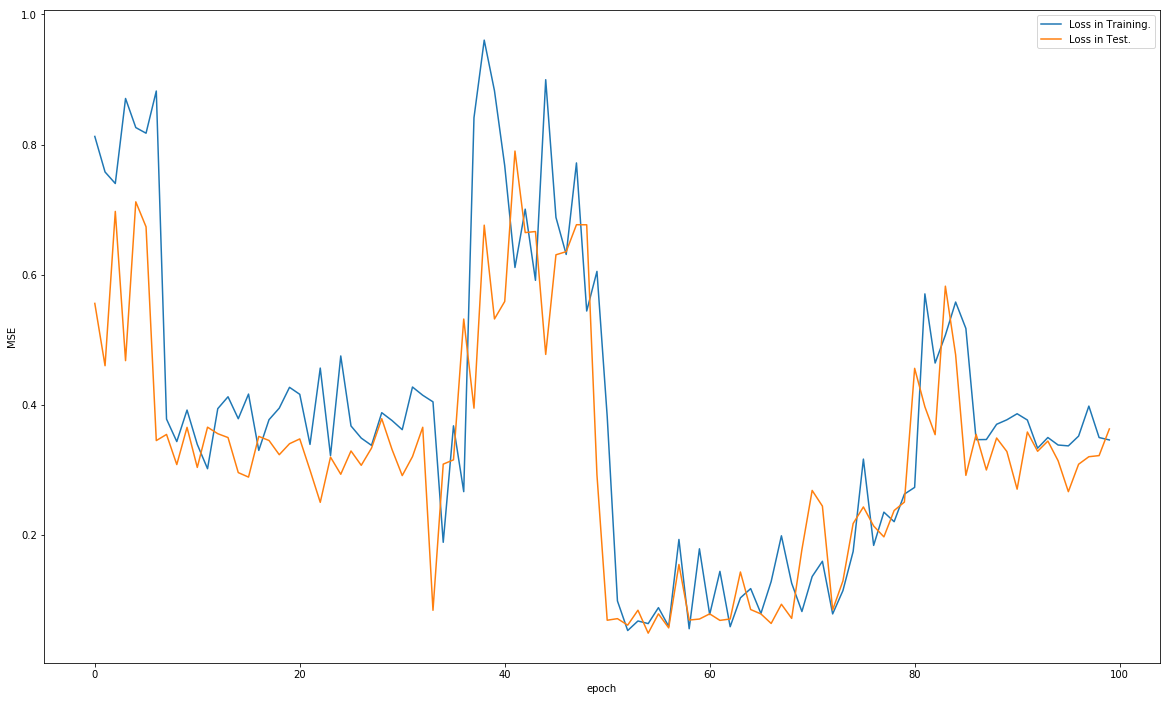

In [15]:
# Logging the loss.
fig = plt.figure(figsize=(20, 12))
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.train_loss.values, label="Loss in Training.")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.test_loss.values, label="Loss in Test.")
plt.legend()
plt.show();plt.close()

At first glance, the model will get better. But in carrying out the function of the reconstrcution model or Encoder/Decoder scheme, there is no problem even with this degree.

### Inference and reconsturct Gold prices.

If observed data points are in normal series, inferenced feature points follow the data points. But, if not, the differences between observed data points and infereced feature points, that is, the reconstrcution error can be higher.

In [21]:
result_arr = encoder_decoder_controller.inference(observed_arr)
loss_arr = np.abs(observed_arr[:, -1] - result_arr[:, -1])

In [32]:
def min_max(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

loss_arr = np.sqrt(np.power(min_max(observed_arr[:, -1]) - min_max(result_arr[:, -1]), 2).sum(axis=1))

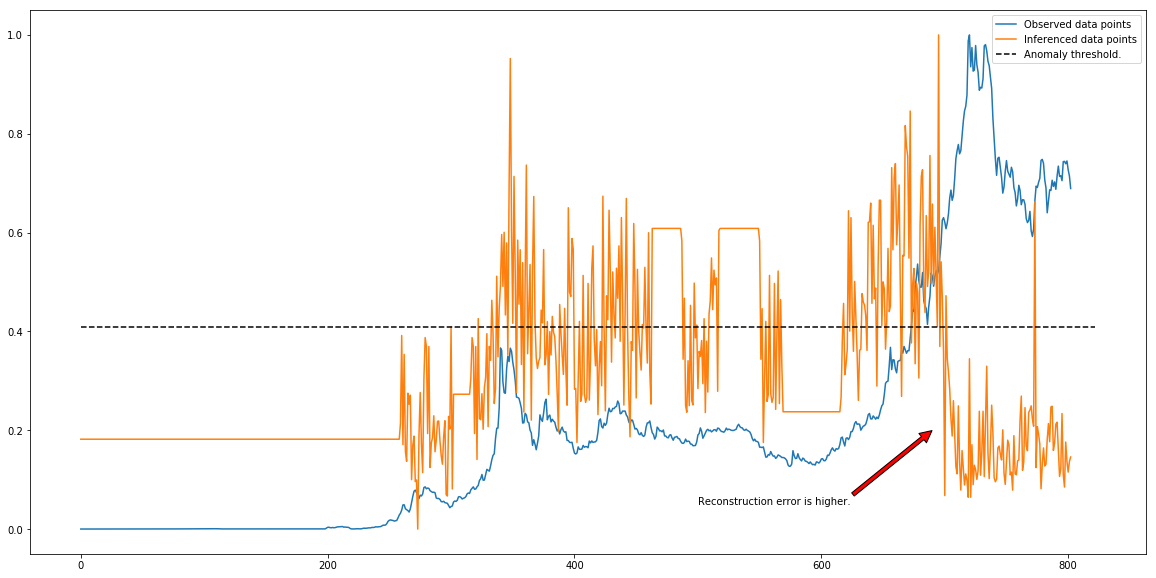

In [84]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(min_max(observed_arr[:, -1, :]), label="Observed data points")
ax1.plot(min_max(result_arr[:, -1, :]), label="Inferenced data points")
ax1.plot(np.array([(750 - df.price.min())/(df.price.max()-df.price.min())] * df.shape[0]), label="Anomaly threshold.", color="black", linestyle='dashed')
ax1.annotate('Reconstruction error is higher.', xy=(690, 0.2), xytext=(500, 0.05),
            arrowprops=dict(facecolor='red', shrink=0.005),
            )

ax1.legend()
plt.show()
plt.close()

### The distribution of Reconstruction Error

The distribution of Reconstruction Error is as follows.

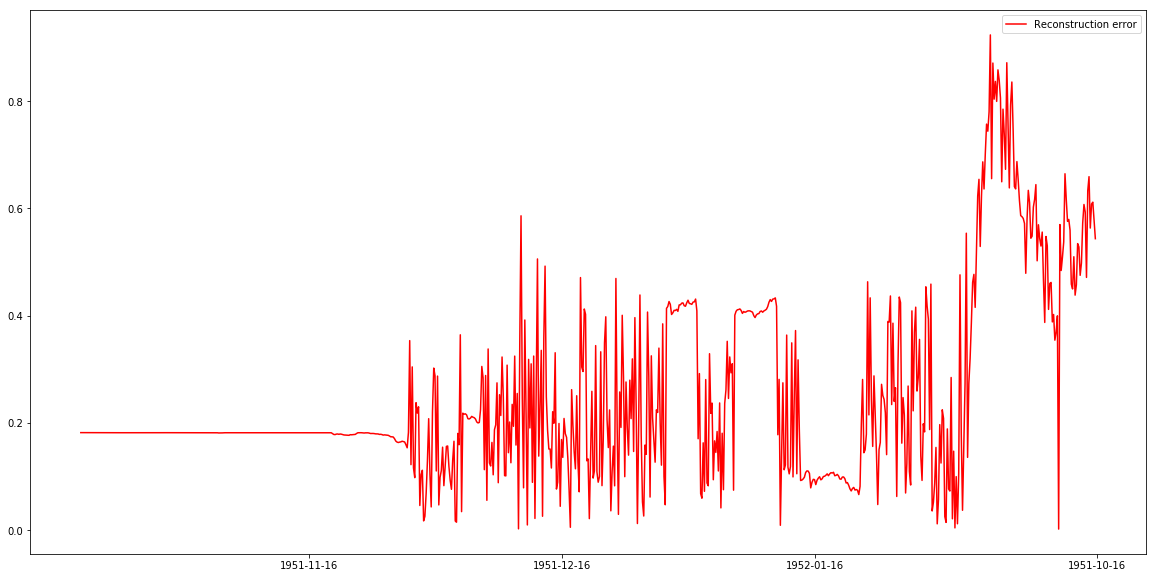

In [78]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(df.date.values[20:], loss_arr, label="Reconstruction error", color="red")
ax1.set_xticks([df.date.values[0], df.date.values[200], df.date.values[400], df.date.values[600]])
ax1.legend()
plt.show()
plt.close()

# References

- Malhotra, P., Ramakrishnan, A., Anand, G., Vig, L., Agarwal, P., & Shroff, G. (2016). LSTM-based encoder-decoder for multi-sensor anomaly detection. arXiv preprint arXiv:1607.00148.